In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import scipy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import toolbelt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
def make_dataset_v1(_df, include_y=True):
    # Fill Our Null Age with the mean from the training set
    _df.Age = _df.Age.fillna(29.69911764705882)
    # Fill Missing Embarked with most common value:
    _df.Embarked = _df.Embarked.fillna('S')
    # Create new column for "no_cabin"
    _df['no_cabin'] = _df.Cabin.isnull().astype(int)
    # Create new column for those with 0 fare
    _df['zero_fare'] = (_df.Fare<1).astype(int)
    # Fill Zero Fares with the mean of non-zero fares
    _df.Fare = _df.Fare.apply(lambda x: x if x!=0 else 32.75564988584471)
    # SibSp & Parch to Categories
    family_counts = {0: "0_1", 1: "0_1", 2: "2_3", 3: "2_3"}
    _df.SibSp = _df.SibSp.apply(lambda x: family_counts[x] if x in family_counts.keys() else "4+")
    _df.Parch = _df.Parch.apply(lambda x: family_counts[x] if x in family_counts.keys() else "4+")
    # Log of Fare
    _df.Fare = np.log(_df.Fare)
    # Categorical Columns
    X_cat = ["Embarked", "no_cabin", "zero_fare", "Sex", "Pclass", "SibSp", "Parch"]
    _df.Pclass = _df.Pclass.astype(str)
    X_cont = ["Age", "Fare"]
    
    dfX = pd.get_dummies(_df[X_cat + X_cont], drop_first=True)
    
    if include_y:
        if "Survived" in _df.columns.values:
            return dfX.values, _df.Survived.values, list(dfX.columns.values)
        else:
            return dfX.values, None, list(dfX.columns.values)
    else:
        return X, list(dfX.columns.values)

In [3]:
X, y, cols = make_dataset_v1(pd.read_csv('./titanic/train.csv', index_col='PassengerId'))
X.shape, y.shape, np.mean(y)

((891, 13), (891,), 0.3838383838383838)

In [4]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [6]:
rfc = RandomForestClassifier(n_estimators=512, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
pred_y = rfc.predict(X_test)

cm = sklearn.metrics.confusion_matrix(y_test, pred_y)
tn, fp, fn, tp = cm.ravel()
print('   A1\tA0\nP1[{}\t{}\t]\nP0[{}\t{}\t]'.format(tp, fp, fn, tn), end='\n\n')
print(f'precision: {tp/(tp+fp)}')
print(f'recall: {tp/(tp+fn)}')
print(f'log loss: {sklearn.metrics.log_loss(y_test, rfc.predict_proba(X_test))}')
print(f'type1 error: {fp}')

   A1	A0
P1[64	26	]
P0[25	108	]

precision: 0.7111111111111111
recall: 0.7191011235955056
log loss: 0.4629708186371013
type1 error: 26


In [7]:
important_features = pd.DataFrame([x for x in zip(cols, rfc.feature_importances_)], columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
important_features

,Feature,Importance
2,Age,0.289975
3,Fare,0.281213
6,Sex_male,0.227221
8,Pclass_3,0.053032
0,no_cabin,0.038697
5,Embarked_S,0.023610
7,Pclass_2,0.020134
11,Parch_2_3,0.017678
9,SibSp_2_3,0.013353
10,SibSp_4+,0.011790


# Should we structure our data differently?

In [8]:
def make_dataset_v2(_df, include_y=True):
    # Fill Our Null Age with the mean from the training set
    _df.Age = _df.Age.fillna(29.69911764705882)
    # Fill Missing Embarked with most common value:
    _df.Embarked = _df.Embarked.fillna('S')
    # Create new column for "no_cabin"
    _df['no_cabin'] = _df.Cabin.isnull().astype(int)
    
    #### CHANGE #####
    # Create new column for those with 0 fare
    #_df['zero_fare'] = (_df.Fare<1).astype(int)
    # Fill Zero Fares with the mean of non-zero fares
    #_df.Fare = _df.Fare.apply(lambda x: x if x!=0 else 32.75564988584471)
    
    
    # SibSp & Parch to Categories
    #family_counts = {0: "0_1", 1: "0_1", 2: "2_3", 3: "2_3"}
    #_df.SibSp = _df.SibSp.apply(lambda x: family_counts[x] if x in family_counts.keys() else "4+")
    #_df.Parch = _df.Parch.apply(lambda x: family_counts[x] if x in family_counts.keys() else "4+")
    
    # Log+1 of Fare
    _df.Fare = np.log1p(_df.Fare)
    ##############
    
    # Categorical Columns
    X_cat = ["Embarked", "no_cabin", "Sex", "Pclass", ]
    _df.Pclass = _df.Pclass.astype(str)
    X_cont = ["Age", "Fare", "SibSp", "Parch"]
    
    dfX = pd.get_dummies(_df[X_cat + X_cont], drop_first=True)
    
    if include_y:
        if "Survived" in _df.columns.values:
            return dfX.values, _df.Survived.values, list(dfX.columns.values)
        else:
            return dfX.values, None, list(dfX.columns.values)
    else:
        return X, list(dfX.columns.values)

In [9]:
X2, y2, cols2 = make_dataset_v2(pd.read_csv('./titanic/train.csv', index_col='PassengerId'))
X2.shape, y2.shape, np.mean(y2)

((891, 10), (891,), 0.3838383838383838)

In [10]:
X_train_raw2, X_test_raw2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=42)
scaler2 = StandardScaler()
scaler2.fit(X_train_raw2)
X_train2 = scaler2.transform(X_train_raw2)
X_test2 = scaler2.transform(X_test_raw2)

In [11]:
rfc = RandomForestClassifier(n_estimators=512, criterion='entropy', n_jobs=-1, random_state=42)
rfc.fit(X_train2, y_train2)
rfc_pred_y = rfc.predict(X_test2)

cm = sklearn.metrics.confusion_matrix(y_test2, rfc_pred_y)
tn, fp, fn, tp = cm.ravel()
print('   A1\tA0\nP1[{}\t{}\t]\nP0[{}\t{}\t]'.format(tp, fp, fn, tn), end='\n\n')
print(f'precision: {tp/(tp+fp)}')
print(f'recall: {tp/(tp+fn)}')
print(f'log loss: {sklearn.metrics.log_loss(y_test2, rfc.predict_proba(X_test2))}')
print(f'type1 error: {fp}')

   A1	A0
P1[64	22	]
P0[25	112	]

precision: 0.7441860465116279
recall: 0.7191011235955056
log loss: 0.44518239374567853
type1 error: 22


In [12]:
important_features2 = pd.DataFrame(zip(cols2, rfc.feature_importances_), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
important_features2

,Feature,Importance
2,Fare,0.273453
1,Age,0.267454
7,Sex_male,0.222719
9,Pclass_3,0.053096
3,SibSp,0.050201
0,no_cabin,0.038404
4,Parch,0.037433
6,Embarked_S,0.025851
8,Pclass_2,0.020200
5,Embarked_Q,0.011189


## What About a Different Algorithm?
# LOGISTIC REGRESSION

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

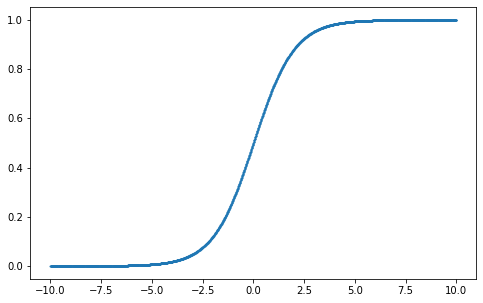

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
pltx = np.arange(-10,10,.01)
plty = list(map(sigmoid, pltx))
plt.scatter(pltx, plty, s=1)
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [16]:
lr = LogisticRegression()
parameters = {'penalty':['l1'], 'C':np.linspace(1e-1, 1e1, num=1001), 'solver':['liblinear']}
clf = GridSearchCV(lr, parameters, scoring="neg_log_loss", cv=5, n_jobs=-1)
clf.fit(X_train2, y_train2)
clf.best_estimator_

LogisticRegression(C=0.6049, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
lr_pred_y = clf.predict(X_test2)

cm = sklearn.metrics.confusion_matrix(y_test2, lr_pred_y)
tn, fp, fn, tp = cm.ravel()
print('   A1\tA0\nP1[{}\t{}\t]\nP0[{}\t{}\t]'.format(tp, fp, fn, tn), end='\n\n')
print(f'precision: {tp/(tp+fp)}')
print(f'recall: {tp/(tp+fn)}')
print(f'log loss: {sklearn.metrics.log_loss(y_test2, clf.predict_proba(X_test2))}')
print(f'type1 error: {fp}')

   A1	A0
P1[65	19	]
P0[24	115	]

precision: 0.7738095238095238
recall: 0.7303370786516854
log loss: 0.4259862553094603
type1 error: 19


In [18]:
pd.DataFrame(zip(cols, clf.best_estimator_.coef_[0]), columns=['Feature', 'Coef']).sort_values(by='Coef')

,Feature,Coef
7,Pclass_2,-1.232474
0,no_cabin,-0.454282
1,zero_fare,-0.389829
3,Fare,-0.360105
9,SibSp_2_3,-0.290985
6,Sex_male,-0.207279
4,Embarked_Q,-0.169385
5,Embarked_S,-0.012405
8,Pclass_3,0.201790
2,Age,0.359532


# How does Logit Perform against the original data set?
# Does it agree about the "feature importances" ?

In [21]:
lr2 = LogisticRegression()
parameters2 = {'penalty':['l1'], 'C':np.linspace(1e-1, 1e1, num=1001), 'solver':['liblinear']}
clf2 = GridSearchCV(lr2, parameters2, scoring="neg_log_loss", cv=5, n_jobs=-1)
clf2.fit(X_train, y_train)
print(clf2.best_estimator_)
print('-'*75)
lr2_pred_y = clf2.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, lr2_pred_y)
tn, fp, fn, tp = cm.ravel()
print('   A1\tA0\nP1[{}\t{}\t]\nP0[{}\t{}\t]'.format(tp, fp, fn, tn), end='\n\n')
print(f'precision: {tp/(tp+fp)}')
print(f'recall: {tp/(tp+fn)}')
print(f'log loss: {sklearn.metrics.log_loss(y_test, clf2.predict_proba(X_test))}')
print(f'type1 error: {fp}')
print('-'*75)
lr_coefs = pd.DataFrame(zip(cols, clf2.best_estimator_.coef_[0]), columns=['Feature', 'Coef']).sort_values(by='Coef').set_index('Feature')
features = lr_coefs.join(important_features.set_index('Feature')).rename(columns={"Importance": "RFC_Importance", "Coef":"LR_Coef"})
features.sort_values(by='RFC_Importance', ascending=False)

LogisticRegression(C=0.2782, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
---------------------------------------------------------------------------
   A1	A0
P1[64	19	]
P0[25	115	]

precision: 0.7710843373493976
recall: 0.7191011235955056
log loss: 0.4273443390815332
type1 error: 19
---------------------------------------------------------------------------


,LR_Coef,RFC_Importance
Feature,,
Age,-0.322652,0.289975
Fare,0.138579,0.281213
Sex_male,-1.187901,0.227221
Pclass_3,-0.449948,0.053032
no_cabin,-0.380192,0.038697
Embarked_S,-0.182496,0.023610
Pclass_2,0.047795,0.020134
Parch_2_3,-0.049090,0.017678
SibSp_2_3,-0.121430,0.013353


In [23]:
features.iloc[(-features.LR_Coef.abs()).argsort()]

,LR_Coef,RFC_Importance
Feature,,
Sex_male,-1.187901,0.227221
Pclass_3,-0.449948,0.053032
no_cabin,-0.380192,0.038697
Age,-0.322652,0.289975
Parch_4+,-0.284334,0.005571
SibSp_4+,-0.228638,0.011790
Embarked_S,-0.182496,0.023610
Fare,0.138579,0.281213
zero_fare,-0.133426,0.007321


# Why:

- L1 Regularization (vs L2)
- Difference in Algorithms